# Repository Footprint Analysis: Post-processing

### This file compares the repositry footprint results from various reactors. Results are first shown for a specific reactor. Then comparative plots are made.

In [71]:
%matplotlib inline
import nwpy as nwpy

import pandas as pd
from nwpy import fuelcycle
from nwpy.fuelcycle import stage
from nwpy.plot import TimePlot as tp
from nwpy.repository_area import repository
from nwpy.repository_area import waste
from nwpy import stream
import math
import matplotlib.pyplot as plt
import numpy as np

# Functions

In [72]:
def read_files(reactor,primary_path):
    """
    For each type of reactor, read the output .csv file.
    Returns a list containg the dataframes for each number of waste form per canister 
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    # primary_path (str) - a path to the directory in which openmc files are stored
    ## ---- Returns:
    # list_app - list of area per package for different storage time
    # n_wf - the number of fuel units
    # results - results from the footprint analysis {'Total area (km2)', 'Required st (y)','#packages per GWe.y'}
    
    # Allocate the canister loading for each type of reactors
    if ('PWR' in reactor): 
        n_wf=[1, 2, 3, 4, 12, 21]
    elif ('SFR' in reactor):
        n_wf=[1,3, 7, 19]
    else:
        n_wf=[6, 18, 42, 78, 114]
    results=[]
    # Read the .csv files
    for i in n_wf:
        result = pd.read_csv(primary_path+'Results/'+reactor+'/footprint_clay_'+reactor+'_'+str(i)+'.csv', sep=',', index_col=0)
        result['Power density (GWe.y/Pkg)']=1/result['#packages per GWe.y']
        results.append(result)
    return (n_wf, results)     

In [73]:
def read_files_DH(reactor,primary_path):
    """
    Calculate the decay heat per package
    Return a tuple (list of canister loading, results list).
    The result list contains a the evolution of the decay heat per waste package design.
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    # primary_path (str) - a path to the directory in which openmc files are stored
    ## ---- Returns:
    # list_app - list of area per package for different storage time
    # n_wf - the number of fuel units
    # results - results from the footprint analysis {'Total area (km2)', 'Required st (y)','#packages per GWe.y'}    
    
    # Allocated the corresponding waste package loading to the reactors.
    if ('PWR' in reactor):
        n_wf = [1, 2, 3, 4, 12, 21]
    elif ('SFR' in reactor):
        n_wf = [1,3, 7, 19]
    else:
        n_wf = [6, 18, 42, 78, 114]
    results=[]
    for i in n_wf: # Results the decay heat data from the repository_reactor_N_n_wf.csv file
        path   = primary_path+'Results/'+reactor+'/repository_'+reactor+'_N'+str(i)+ '.csv'
        result = pd.read_csv(path, sep=',', header=0, names=['Decay heat'])
        results.append(result.iloc[7:, :]) # keep only the decay heat values
    return (n_wf, results)

In [74]:
def get_min_area(results, n_wf, st):
    """
    Find the minimum for each reactor with a given storage time
    Returns the minimum total area over the range of canister loading, for a given surface storage time
    """
    ## ---- Parameters:
    # reactor (str) - reactor name
    # primary_path (str) - a path to the directory in which openmc files are stored
    # n_wf: # fuel units per package
    # st: storage time
    ## ---- Returns:
    # min_area: minimum repository area
    # min_n_wf: n_wf to give the minimum area
    # min_N_pkg: #packages for the minimum area
    
    mat = np.zeros((len(n_wf),2))
    for i in range (len(n_wf)):
        area=np.array(results[i].loc[st,'Total area (km2)'])
        area[area<1e-10]=1e10
        mat[i,0] = area
        mat[i,1] = results[i].loc[st,'#packages per GWe.y']
    idx = np.nanargmin(mat[:,0])
    min_area  = mat[idx,0]
    min_n_wf  = n_wf[idx]
    min_N_pkg = mat[idx,1]
    
    return (min_area, min_n_wf, min_N_pkg)

In [75]:
def min_area_reactors_st(reactors, primary_path, st):
    """
    Returns a dataframe with the reactors minimum area for the input surface storage time
    """
    df_min = pd.DataFrame(columns=['Minimum,m^2', 'n_wf'])
    for reactor in reactors:
        n_wf, results=read_files(reactor, primary_path)
        min_area, n_wf_min, min_N_pkg = get_min_area(results, n_wf, st)

        df_min.loc[reactor,'Minimum,m^2']= min_area*1e6
        df_min.loc[reactor,'n_wf']= n_wf_min
        df_min.loc[reactor,'#packages per GWe.y'] = min_N_pkg
        
        n_wf1, results1=read_files_DH(reactor,primary_path)
        idx = n_wf1.index(int(n_wf_min))
        time = [float(t) for t in results1[idx].index.tolist()]
        idx0 =np.where(np.array(time) > st)[0].tolist()
        df_min.loc[reactor, 'Decay heat (W/Pkg)'] = float(results1[idx].iloc[idx0[0]])
    return df_min
        

In [76]:
def addlabels_upper(x,y,s):
    for i in range(len(x)):
        plt.text(i, y[i]*1.001, s[i], ha = 'center', fontsize=12, bbox = dict(facecolor = 'brown', alpha =.6))

In [77]:
def addlabels_center(x,y,n):
    for i in range(len(x)):
        plt.text(i, y[i]/2, 'n: '+str(n[i]), ha = 'center',fontsize=12)

In [78]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',fontsize=12)

# Example 

In [79]:
reactors = ['Ref_PWR', 'SPWR','HTGR', 'HPR', 'HTGR_FCM', 'SFR']
reactors_legend = reactors
primary_path = './'

In [80]:
reactor = 'HTGR' # name of the reactor to study

In [81]:
n_wf, results= read_files(reactor,primary_path)

Plot the area per package in function of the surface storage time for each waste package loading

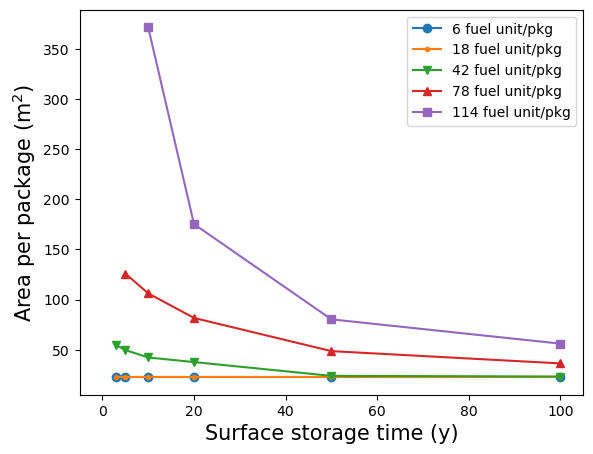

In [82]:
linestyle=['--', '-', ':', '-.', '--', '-']
markers=['o', '.', 'v', '^', 's', "*", "+", "x"]

st=results[0].index.tolist() # select the storage time as the abscisse for the graph

plt.subplots(figsize=(6.5, 5))
for n in range(len(n_wf)):
    y =results[n]['Area per package (m2)']
    y[y<1e-6] = np.nan
    x = results[n].index.tolist()
    l = linestyle[n]
    m = markers[n]
    plt.plot(x, y, linestyle='-', label=str(n_wf[n])+ ' fuel unit/pkg', marker=m) 
plt.xlabel('Surface storage time (y)', fontsize=15)
plt.ylabel(r'Area per package (m$^2$)', fontsize=15)
#plt.title('Area per package for the '+ reactor+' in function of surface storage time')
plt.xlim([-5, 105])
plt.legend(loc='best')

Plot the total area in function of the surface storage time for each waste package loading

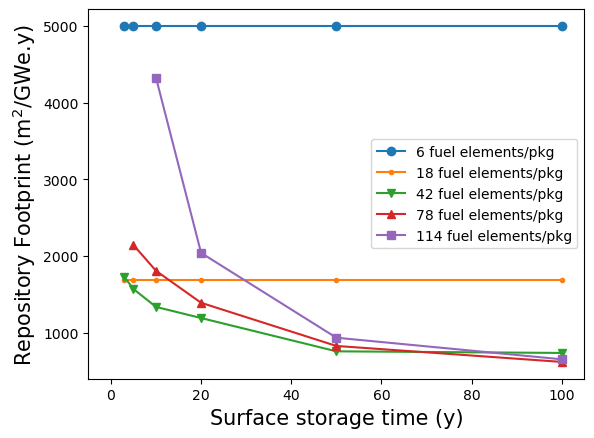

In [83]:
for n in range(len(n_wf)):
    y =results[n]['Total area (km2)']*1e6
    y[y<1e-6] = np.nan
    x =results[n].index.tolist() # select the storage time as the abscisse for the graph
    N_pkg = np.array(results[n]['#packages per GWe.y'])
    N_pkg = [math.ceil(N_pkg[i]) for i in range(len(N_pkg))]
    l = linestyle[n]
    m = markers[n]
    plt.plot(x, y, linestyle='-', label=str(n_wf[n])+ ' fuel elements/pkg', marker=m)
plt.xlabel('Surface storage time (y)', fontsize=15)
plt.ylabel(r'Repository Footprint (m$^2$/GWe.y)', fontsize=15)
plt.xlim([-5, 105])
plt.legend(loc='best')

Plot the total area in function of the loading, depending on the surface storage

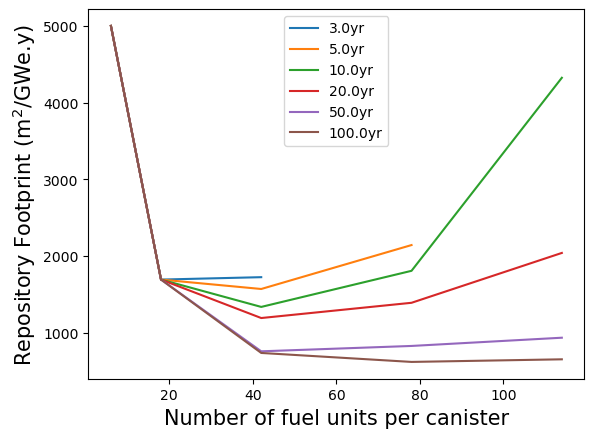

In [84]:
linestyle=['--', '-', ':', '-.', '--', '-', ':']
st=results[0].index.tolist() # select the storage time

for storagetime in st:
    tot_area=[]
    for n in range (len(n_wf)):
        value=results[n].loc[storagetime,'Total area (km2)']*1e6
        tot_area.append(value)
    x = [n_wf[i] for i in range (len(n_wf)) if (tot_area[i]!=0.0)]
    y = [val for val in tot_area if (val!=0.0)]
    l = linestyle[0]
    plt.plot(x, y, label=str(storagetime)+'yr')
plt.xlabel('Number of fuel units per canister', fontsize=15)
plt.ylabel(r'Repository Footprint (m$^2$/GWe.y)', fontsize=15)
plt.legend(loc='best')

Plot decay heat per package 

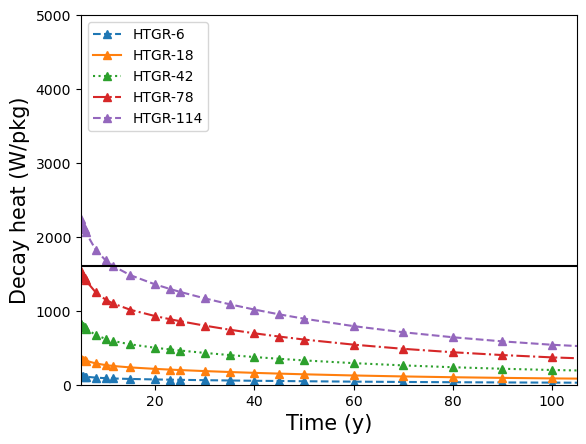

In [85]:
n_wf1, results1=read_files_DH(reactor,primary_path)

linestyle=['--', '-', ':', '-.', '--', '-']
time=results1[0].index.tolist()
time=[float(x) for x in time]

for n in range(len(n_wf1)):
    graph=results1[n].iloc[:, 0].astype(float)
    x = [time[i] for i in range (len(time)) if (graph.iloc[i]!=0.0)]
    y = [val for val in graph if (val!=0.0)]
    l = linestyle[n]
    m = '^'
    plt.plot(x, y, linestyle=l, label=reactor+'-'+str(n_wf[n]), marker=m)
plt.xlabel('Time (y)', fontsize=15)
plt.ylabel('Decay heat (W/pkg)', fontsize=15)
plt.xlim([5, 105])
plt.ylim([0, 5000])
plt.legend(loc=2)
plt.axhline(y=1600, color="black")

Compute minmum area for each reactor type

In [86]:
st=50. # storage time of 50 years
df_min_st=min_area_reactors_st(reactors, primary_path, st)
df_min_st.to_csv('rep_foot_print.csv')
df_min_st

,"Minimum,m^2",n_wf,#packages per GWe.y,Decay heat (W/Pkg)
Ref_PWR,1140.422805,1,48.089592,285.423547
SPWR,957.820797,4,40.074660,262.138866
HTGR,757.039829,42,31.578765,329.141519
HPR,951.573338,42,38.277291,336.200096
HTGR_FCM,1472.269666,18,36.231021,463.018743
SFR,850.671345,3,25.746290,299.242445


Plot the minimum area for each reactor

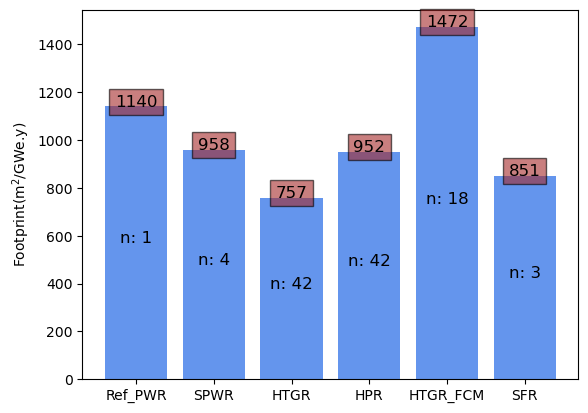

In [87]:
x = np.arange(len(reactors)) # the label locations
n=[i for i in df_min_st['n_wf']]
a=[round(i) for i in df_min_st['Minimum,m^2']]

fig, ax = plt.subplots()

plt.bar(reactors, df_min_st['Minimum,m^2'], color='cornflowerblue')
ax.set_ylabel(r'Footprint(m$^2$/GWe.y)')
#ax.set_title('Total area required to store 1 GWe.year equivalent spent fuel per reactor for a surface storage time of '+ str(st))
ax.set_xticks(x)
ax.set_xticklabels(reactors_legend)
     
# calling the function to add value labels
addlabels_center(x, df_min_st['Minimum,m^2'], n)
addlabels_upper(x, df_min_st['Minimum,m^2'], a)

plt.show()